**Домашнее задание**

Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from arch import arch_model
%matplotlib inline

import warnings
warnings.filterwarnings(action='once')

In [2]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")["Count"]

В первую очередь посмотрим с чем имеем дело.

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
Lags Used                      12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


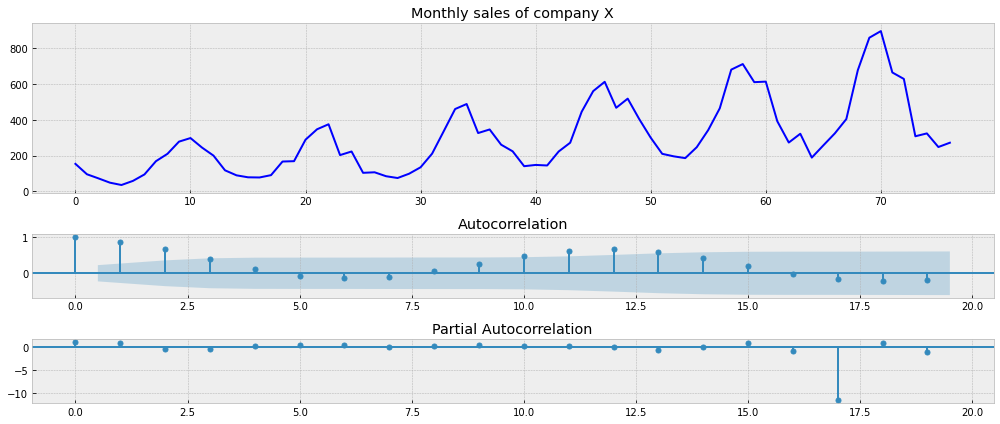

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 6), style='bmh', title='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return


tsplot(sales_of_company_x, title="Monthly sales of company X")

Очевидно, что график нестационарный, имеется и тренд и сезонность. С трендом ARIMA должна справиться.

Методом грубой силы подберем параметры для формулы ARIMA, они нам понадобятся в GARCH:
$$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$$  
p - порядок авторегрессии тренда;  
d - порядок изменения тренда (степень дифференцирования);  
q - тренд скользящей средней.

In [4]:
best_aic = np.inf 
best_order = None
best_mdl = None

for p in range(10):
    for d in range(10):
        for q in range(10):
            try:
                tmp_mdl = smt.ARIMA(sales_of_company_x, order=(p, d, q)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except:
                continue


print(f"Подобранные параметры: p = {best_order[0]}, d = {best_order[1]}, q = {best_order[2]}.")

/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Подобранные параметры: p = 3, d = 1, q = 2.


Все значения меньше 10, а, значит, дальше не имеет смысла перебирать.

Модель GARCH описывается формулой (аналог ARMA, только применимо к дисперсии):

$$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$$

Уберем сезонность и тренд.

In [5]:
series = sales_of_company_x.to_numpy()
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
series = series.astype(float)

Построим GARCH-модель.

In [6]:
am = arch_model(series, p=best_order[0], o=best_order[1], q=best_order[2])
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -346.874
Distribution:                  Normal   AIC:                           709.748
Method:            Maximum Likelihood   BIC:                           727.019
                                        No. Observations:                   64
Date:                Thu, Jan 28 2021   Df Residuals:                       56
Time:                        22:10:39   Df Model:                            8
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -1.7367      9.851     -0.176      0.860 [-21.045, 17.57

Построим график остатков дисперсии.

Results of Dickey-Fuller Test:
Test Statistic                 -2.633180
p-value                         0.086332
Lags Used                      10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


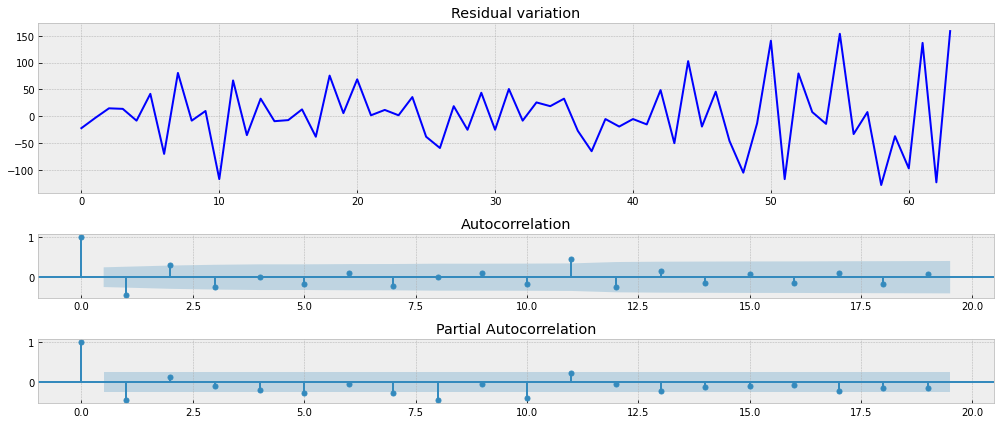

In [7]:
tsplot(res.resid, title="Residual variation")

Модель GARCH справилась с задачей довольно неплохо: p-value невысокий, хотя и больше 0.05.